# Convert Calcium Imaging data from .npz to NWB file
More details on [NWB Calcium imaging data](https://pynwb.readthedocs.io/en/stable/tutorials/domain/ophys.html#calcium-imaging-data).

**0.** We start importing the relevant modules to manipulate NWB file groups and datasets

In [1]:
from datetime import datetime
from dateutil.tz import tzlocal
from pynwb import NWBFile, NWBHDF5IO, ProcessingModule
from pynwb.ophys import TwoPhotonSeries, OpticalChannel, ImageSegmentation, Fluorescence, DfOverF, MotionCorrection
from pynwb.device import Device
from pynwb.base import TimeSeries

import scipy.io
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt

**1.** Importing the data in `.npz` files

In [2]:
files_path = ''

fname1 = '2019_07_01_Nsyb_NLS6s_walk_fly2.npz'
fpath1 = os.path.join(files_path, fname1)
file1 = np.load(fpath1)
print('First file:')
print('Groups:', file1.files)
print('Dims (height,width,depth):', file1['dims'])
print('dFF shape: ', file1['dFF'].shape)

fname2 = '2019_07_01_Nsyb_NLS6s_walk_fly2_A.npz'
fpath2 = os.path.join(files_path, fname2)
file2 = np.load(fpath2)
print('     ')
print('Second file - Sparse Matrix:')
print('Groups:', file2.files)
print('Indices: ', file2['indices'], '  | Shape: ',file2['indices'].shape)
print('Indptr: ', file2['indptr'], '  | Shape: ',file2['indptr'].shape)
print('Format: ', file2['format'])
print('Shape: ', file2['shape'])
print('Data: ', file2['data'], '  | Shape: ',file2['data'].shape)

First file:
Groups: ['time', 'trialFlag', 'dFF', 'ball', 'dlc', 'dims']
Dims (height,width,depth): [[ 90 277 152]]
dFF shape:  (1293, 10293)
     
Second file - Sparse Matrix:
Groups: ['indices', 'indptr', 'format', 'shape', 'data']
Indices:  [  64371   89300   89301 ... 3763753 3763842 3763843]   | Shape:  (30173,)
Indptr:  [    0    43    90 ... 30136 30156 30173]   | Shape:  (1294,)
Format:  b'csc'
Shape:  [3789360    1293]
Data:  [1. 1. 1. ... 1. 1. 1.]   | Shape:  (30173,)


**2.** Create a new NWB file instance, OpticalChannel, ImagingPlane and ProcessingModule.

In [3]:
#Create new NWB file
nwb = NWBFile(session_description='my CaIm recording', 
              identifier='EXAMPLE_ID', 
              session_start_time=datetime.now(tzlocal()),
              experimenter='EXAMPLE_NAME',
              lab='Evan Schaffer lab',
              institution='Columbia University',
              experiment_description='EXPERIMENT_DESCRIPTION',
              session_id='IDX')

#Create and add device
device = Device('Device')
nwb.add_device(device)

# Create an Imaging Plane
fs = 1/file1['time'][0][1]-file1['time'][0][0]
optical_channel = OpticalChannel(name='OpticalChannel',
                                 description='2P Optical Channel',
                                 emission_lambda=510.)
imaging_plane = nwb.create_imaging_plane(name='ImagingPlane',
                                         optical_channel=optical_channel,
                                         description='Imaging plane',
                                         device=device,
                                         excitation_lambda=488., 
                                         imaging_rate=fs,
                                         indicator='NLS-GCaMP6s',
                                         location='whole central brain')

#Dimensions
Xp = file1['dims'][0][0]
Yp = file1['dims'][0][1]
Zp = file1['dims'][0][2]
T = file1['dFF'].shape[1]
nCells = file1['dFF'].shape[0]

#Creates ophys ProcessingModule and add to file
ophys_module = ProcessingModule(name='ophys',
                                description='contains optical physiology processed data.')
nwb.add_processing_module(ophys_module)


ophys <class 'pynwb.base.ProcessingModule'>
Fields:
  description: contains optical physiology processed data.

**3.** Now transform the lists of indices into (xp,yp,zp) masks. With the masks created, we can add them to a plane segmentation class.

In [4]:
def make_voxel_mask(indices, dims):
    """
    indices - List with voxels indices, e.g. [64371, 89300, 89301, ..., 3763753, 3763842, 3763843]
    dims - (height, width, depth) in pixels
    """
    voxel_mask = []
    for ind in indices:
        zp = np.floor(ind/(dims[0]*dims[1])).astype('int')
        rest = ind%(dims[0]*dims[1])
        yp = np.floor(rest/dims[0]).astype('int')
        xp = rest%dims[0]
        voxel_mask.append((xp,yp,zp,1))
    
    return voxel_mask 
        
#Call function
indices = file2['indices']
indptr = indices[file2['indptr'][0:-1]]
dims = np.squeeze(file1['dims'])
voxel_mask = make_voxel_mask(indptr, dims)

#Create Image Segmentation compartment
img_seg = ImageSegmentation()
ophys_module.add(img_seg)

#Create plane segmentation and add ROIs
ps = img_seg.create_plane_segmentation(description='plane segmentation',
                                       imaging_plane=imaging_plane)
ps.add_roi(voxel_mask=voxel_mask)

**4.** The file contains two arrays with pixel indexing: one with all pixels at cells and one with only one reference pixel per cell. Let's see how it looks like in a 3D plot:

<IPython.core.display.Javascript object>


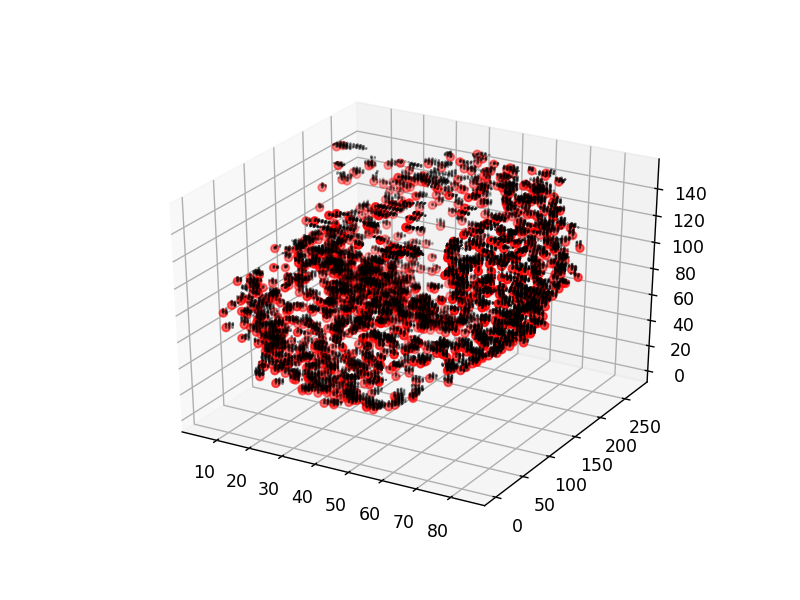

In [5]:
#3D scatter with masks points
from mpl_toolkits.mplot3d import Axes3D

#Reference points
xptr = [p[0] for p in voxel_mask]
yptr = [p[1] for p in voxel_mask]
zptr = [p[2] for p in voxel_mask]

#All points in mask
all_pt_mask = make_voxel_mask(indices, dims)
x = [p[0] for p in all_pt_mask]
y = [p[1] for p in all_pt_mask]
z = [p[2] for p in all_pt_mask]

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='k', marker='.', s=.5)
ax.scatter(xptr, yptr, zptr, c='r', marker='o', s=20)

**5.** With the ROIs created, we can add the dF/F data

In [6]:
#DFF measures
dff = DfOverF(name='DfOverF')
ophys_module.add(dff)

#create ROI regions
roi_region = ps.create_roi_table_region(description='RoiTableRegion', 
                                        region=[0])

#create ROI response series
dff_data = file1['dFF']
dFF_series = dff.create_roi_response_series(name='RoiResponseSeries',
                                            data=dff_data,
                                            unit='NA',
                                            rois=roi_region,
                                            rate=fs)

**6.** Saving the NWB file

In [7]:
#Saves to NWB file
path_to_files = ''
fname_nwb = 'file_1.nwb'
fpath_nwb = os.path.join(path_to_files, fname_nwb)
with NWBHDF5IO(fpath_nwb, mode='w') as io:
    io.write(nwb)
print('File saved with size: ', os.stat(fpath_nwb).st_size/1e6, ' mb')

File saved with size:  106.676736  mb


**7.** Loading and checking the new NWB file

In [8]:
#Loads NWB file
with NWBHDF5IO(fpath_nwb, mode='r') as io:
    nwb = io.read()
    print(nwb)


root <class 'pynwb.file.NWBFile'>
Fields:
  devices: {
    Device <class 'pynwb.device.Device'>
  }
  experiment_description: EXPERIMENT_DESCRIPTION
  experimenter: EXAMPLE_NAME
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Columbia University
  lab: Evan Schaffer lab
  processing: {
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  session_id: IDX

